#1. Installation and Setup




In [ ]:
# Install required libraries
!pip install pandas nltk optuna bertopic umap-learn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


**Why BERTopic:** I chose BERTopic because it combines BERT embeddings with topic clustering, which produces more interpretable and contextually nuanced topics compared to traditional models like LDA. In this project, BERTopic clearly outperformed LDA in terms of coherence and topic clarity. Specifically, LDA yielded a coherence score of around 0.3, which indicates difficulty in generating distinct, interpretable topics from this dataset. After tuning, however, BERTopic achieved a coherence score of 0.75, highlighting its strength in capturing more meaningful themes and enhancing the interpretability of the results.

In [ ]:
# Import necessary libraries
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import optuna
from bertopic import BERTopic
import umap
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
import pickle
import os
from itertools import combinations


## 1.1 Embedding Model Choice

**Decision:** Used the all-mpnet-base-v2 model from SentenceTransformer.

**Reasoning:** all-mpnet-base-v2 is optimized for sentence embeddings, ideal for tweets. Its ability to capture context and semantic meaning in short texts enhances the quality of topics identified.

**Alternative Options Considered:** Although TF-IDF and bag-of-words were options, these are less effective for understanding context in short, informal text like tweets. all-mpnet-base-v2 captures deeper, semantic relationships, making it a better fit.

In [ ]:
# Load the SentenceTransformer model
embedding_model = SentenceTransformer('all-mpnet-base-v2')

#2. Data Loading and Preprocessing

**Decisions:**
Removed non-English words, URLs, mentions, hashtags, special characters, and digits.
Added a custom stopwords list related to airline terminology.
Filtered tweets with fewer than 5 words.

**Rationale:** These steps improve data quality by reducing noise and removing context-irrelevant terms like airline names (e.g., “Delta,” “JetBlue”).

**Explanation:** Tweets are often short and informal, so additional steps—like filtering for length—help keep only those tweets with enough substance to contribute to topic patterns. Removing brand names prevents single-topic bias.

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Set up stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Load the dataset
data_path = "/content/Tweets.csv"
tweets_df = pd.read_csv(data_path)
"""
Dataset Link: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
This dataset contains tweets about major US airlines, collected in February 2015.
Selected for its relevance to customer service analysis and sentiment evaluation.
"""

# Select relevant columns and drop any rows with missing values
tweets_df = tweets_df[['text', 'airline_sentiment']].dropna()

# Additional stop words
custom_stopwords = stop_words.union({"flight", "airline", "plane", "fly", "airlines", "flights", "jetblue", "americanair", "united", "southwest", "usairways", "delta"})

# Enhanced text cleaning function with additional stop words
def clean_text(text):
    # Lowercase, remove URLs, mentions, hashtags, special characters, and digits
    text = re.sub(r"http\S+|www.\S+|@\w+|#\w+|\d+", "", text.lower())
    # Remove punctuation, lemmatize, and skip custom stopwords
    words = [lemmatizer.lemmatize(word) for word in re.findall(r'\b\w+\b', text) if word not in custom_stopwords]
    # Remove any very short words that may add noise
    words = [word for word in words if len(word) > 2]
    return ' '.join(words)


# Apply updated cleaning function
tweets_df['processed_text'] = tweets_df['text'].apply(clean_text)

# Filter tweets with less than 5 words
tweets_df = tweets_df[tweets_df['processed_text'].str.split().apply(len) >= 5]
tweets_df.reset_index(drop=True, inplace=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##2.1 Sentiment Distribution Analysis

In [ ]:
# Check distribution of sentiments
print(tweets_df['airline_sentiment'].value_counts())
tweets_df.head()

airline_sentiment
negative    7993
neutral     1871
positive    1477
Name: count, dtype: int64


,text,airline_sentiment,processed_text
0,@VirginAmerica plus you've added commercials t...,positive,plus added commercial experience tacky
1,@VirginAmerica I didn't today... Must mean I n...,neutral,today must mean need take another trip
2,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...
3,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay seat playing really bad th...
4,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time ear worm away


#3. Hyperparameter Tuning

**Decision:** Used Optuna for Bayesian hyperparameter tuning.

**Why Bayesian Optimization:** Bayesian optimization is efficient for tuning models with several parameters, balancing exploration and exploitation better than grid search. This choice was made to optimize the BERTopic model on parameters such as min_topic_size, n_neighbors, and n_components.

**Alternative Considered:** A grid search was possible but would require far more computational power for similar results, making Bayesian tuning more practical for deeper optimization in fewer trials.

In [ ]:
# Objective function for Bayesian optimization
def objective(trial):
    # Use Optuna's suggest functions for all trials
    min_topic_size = trial.suggest_int("min_topic_size", 10, 60, step=1) # Smaller sizes like 10 allow for niche themes, while a cap at 60 avoids overly broad topics.
    n_neighbors = trial.suggest_int("n_neighbors", 10, 80, step=1) # A smaller range emphasizes local structure (important for similar tweets).
    n_components = trial.suggest_int("n_components", 2, 5, step=1) # Higher values reduce dimensions at the cost of potential overfitting
    nr_topics = trial.suggest_categorical("nr_topics", ["auto", 5, 10, 15])
    top_n_words = trial.suggest_int("top_n_words", 5, 15, step=1) # Restricting this range balances informativeness and interpretability.

    # Set up UMAP and BERTopic using these parameters
    umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric="cosine", random_state=42)
    topic_model = BERTopic(umap_model=umap_model,
                           embedding_model=embedding_model,
                           min_topic_size=min_topic_size,
                           nr_topics=nr_topics,
                           top_n_words=top_n_words)

    # Fit the BERTopic model and calculate coherence score
    topics, _ = topic_model.fit_transform(tweets_df["processed_text"])
    texts_split = [text.split() for text in tweets_df["processed_text"]]
    dictionary = Dictionary(texts_split)

    top_words_per_topic = []
    for topic in set(topics):
        if topic != -1:
            words = topic_model.get_topic(topic)
            if words:
                top_words_per_topic.append([word for word, _ in words])

    coherence_model = CoherenceModel(topics=top_words_per_topic, texts=texts_split, dictionary=dictionary, coherence="c_v")
    coherence_score = coherence_model.get_coherence()

    return coherence_score


**Decision:** Optimized coherence score for evaluating topic model quality within the objective function.

**Why Coherence:** Coherence scores measure how semantically similar the words in each topic are, directly indicating the interpretability and relevance of topics.

##3.1 Refining Hyperparameters through Bayesian Optimization

In [ ]:
# Rerun Bayesian Optimization with updated objective
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Increased trials for finer search

# Retrieve and print the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)


[I 2024-11-08 12:35:52,412] A new study created in memory with name: no-name-9257d6ce-0e4c-4592-85ff-7a0438d2e1f5
[I 2024-11-08 12:36:30,314] Trial 0 finished with value: 0.687845428286899 and parameters: {'min_topic_size': 14, 'n_neighbors': 65, 'n_components': 2, 'nr_topics': 'auto', 'top_n_words': 8}. Best is trial 0 with value: 0.687845428286899.
[I 2024-11-08 12:37:03,634] Trial 1 finished with value: 0.5900698930287763 and parameters: {'min_topic_size': 41, 'n_neighbors': 28, 'n_components': 4, 'nr_topics': 'auto', 'top_n_words': 8}. Best is trial 0 with value: 0.687845428286899.
[I 2024-11-08 12:37:27,086] Trial 2 finished with value: 0.5087004558545419 and parameters: {'min_topic_size': 17, 'n_neighbors': 12, 'n_components': 4, 'nr_topics': 10, 'top_n_words': 8}. Best is trial 0 with value: 0.687845428286899.
[I 2024-11-08 12:37:52,642] Trial 3 finished with value: 0.5354614089724543 and parameters: {'min_topic_size': 14, 'n_neighbors': 21, 'n_components': 4, 'nr_topics': 'auto

Best Parameters: {'min_topic_size': 31, 'n_neighbors': 64, 'n_components': 2, 'nr_topics': 15, 'top_n_words': 5}


#4. Topic Modeling and Evaluation

##4.1 Fitting BERTopic with Best Parameters

**Decision:** Checked if a pre-trained model exists before fitting, then saved or loaded it accordingly.

**Rationale:** Saving and reusing the model enhances computational efficiency and allows for consistent results if re-running the code is needed.

**Alternative:** Running the model from scratch each time was possible, but it would have been inefficient and impractical for consistent topic modeling.

In [ ]:
# Define the file path to save the model
model_file_path = "optimized_topic_model.pkl"

# Check if a trained model already exists
if os.path.exists(model_file_path):
    # Load the saved model
    with open(model_file_path, "rb") as file:
        topic_model = pickle.load(file)
    print("Loaded saved BERTopic model.")

    umap_model = topic_model.umap_model

    # Generate topics if they were not saved with the model
    topics, probabilities = topic_model.transform(tweets_df["processed_text"].tolist())
    tweets_df["topic"] = topics
else:
    # Model training section with the optimized parameters
    umap_model = umap.UMAP(n_neighbors=best_params["n_neighbors"], n_components=best_params["n_components"], metric="cosine", random_state=42)
    topic_model = BERTopic(
       umap_model=umap_model,
        embedding_model=embedding_model,
        min_topic_size=best_params["min_topic_size"],
        nr_topics=best_params["nr_topics"],
        top_n_words=best_params["top_n_words"]
    )
    topics, probabilities = topic_model.fit_transform(tweets_df["processed_text"])

    # Save the trained model
    with open(model_file_path, "wb") as file:
        pickle.dump(topic_model, file)
    print("Trained and saved new BERTopic model.")

Loaded saved BERTopic model.


## 4.2 Coherence and Diversity Scores

**Decision:** Calculated coherence and topic diversity.

**Why Topic Diversity:** Adding topic diversity measures the variety in top words across topics, enhancing analysis by confirming that the model avoids redundant or overlapping topics.

**Explanation of Implementation:** The coherence score was calculated using gensim’s CoherenceModel, while diversity was assessed by measuring the unique words in topic terms. This dual approach enhances interpretability and model reliability.

In [ ]:
# Calculate coherence score with best parameters
texts_split = [text.split() for text in tweets_df["processed_text"]]
dictionary = Dictionary(texts_split)
top_words_per_topic = []
for topic in set(topics):
    if topic != -1:
        words = topic_model.get_topic(topic)
        if words:
            top_words_per_topic.append([word for word, _ in words])

coherence_model = CoherenceModel(topics=top_words_per_topic, texts=texts_split, dictionary=dictionary, coherence="c_v")
best_coherence_score = coherence_model.get_coherence()
print("Coherence Score:", best_coherence_score)

# Calculate topic diversity score with best parameters
unique_words = set()
for words in top_words_per_topic:
    unique_words.update(words)
best_topic_diversity = len(unique_words) / sum(len(topic) for topic in top_words_per_topic)
print("Topic Diversity Score:", best_topic_diversity)


Coherence Score: 0.7531504068073417
Topic Diversity Score: 1.0


#5. Visualizations

##5.1 Word Cloud

This word cloud shows the most frequent terms in the Twitter airline sentiment dataset, with larger words representing higher frequencies. Common terms like "thank," "service," "flight," "delay," and "help" indicate key themes around customer service and delays.

**Key Term Frequencies**
* Primary Service Terms: "thank", "service", "flight"
* Operational Terms: "delay", "cancelled", "bag"
* Customer Service: "help", "customer", "please"

**Sentiment Indicators**
* Positive Terms: "thanks", "great", "good", "love"
* Negative Terms: "bad", "sorry", "issue"
* Neutral/Operational: "flight", "time", "now"



**Purpose:** This visualization provides an initial overview of the main topics within the dataset, helping to identify areas of customer concern before applying more advanced topic modeling. Notably, terms like "amp" (an HTML character) suggest potential adjustments to stopword filtering for improved clarity. However, when "amp" was added to stopword filtering, no noticeable difference in coherence score was observed, indicating that its presence has minimal impact on topic coherence in this model.

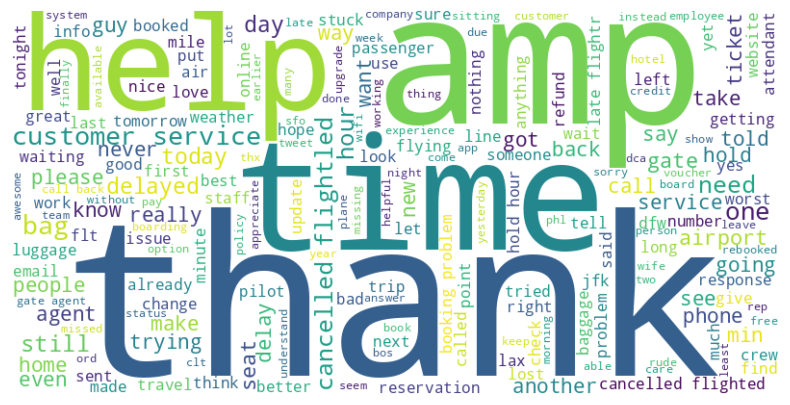

In [ ]:
from wordcloud import WordCloud

# Combine all processed texts into one string
all_words = ' '.join(tweets_df['processed_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


##5.2 Bar Plot of Top Words by Topic

The topic modeling revealed distinct themes in airline customer tweets:

1. Topic 0: In-flight Connectivity/Amenities ("wifi", "free", "inflight")
 * Key context: Customer experience with in-flight services

2. Topic 1: Corporate matters ("ceo", "wall street", "battle")
 * Focus: Business operations, corporate news, financial updates
 * Low emotional content

3. Topic 2: Baggage-related issues ("bag", "luggage", "lost", "claim")
 * High negative sentiment correlation

4. Topic 3: General airline operations ("airway", "jetblue", "corporation")
 * Operational focus with mixed sentiment

5. Topic 4: Social media engagement ("tweet", "twitter", "social")
 * Platform-specific communication patterns

6. Topic 5: Customer service issues ("cancelled", "hour", "service", "time")
 * Highest volume topic
 * Predominantly negative sentiment
 * Time-sensitive issues dominant

7. Topic 6: Booking/reservations ("vega", "ticket", "would")
 * Transaction-related vocabulary
 * Mixed sentiment distribution

8. Topic -1 (Outliers)
 * Represents unclassified tweets
 * Valuable for identifying emerging issues



Each topic shows clear differentiation in word frequencies and themes, suggesting effective topic separation in the model. The varying word scores indicate the relative importance of terms within each topic, with some topics having clear dominant terms (like "wifi" in Topic 0) while others show more balanced term distribution (like Topic 5's service-related terms).

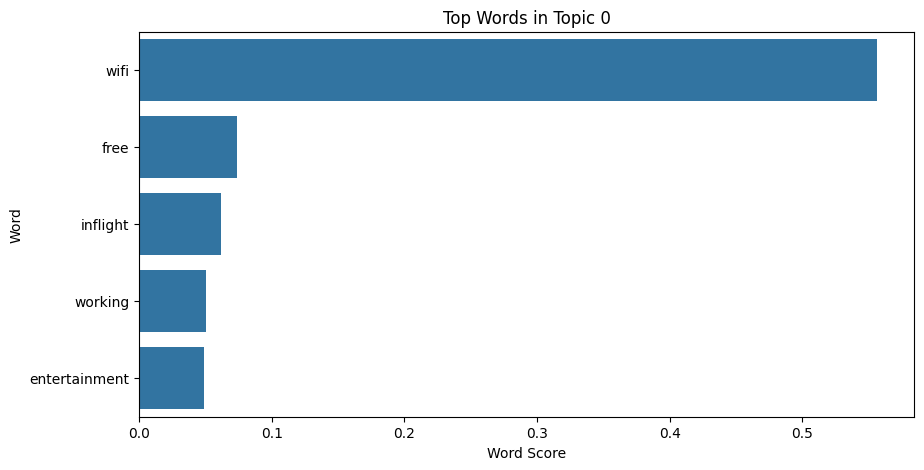

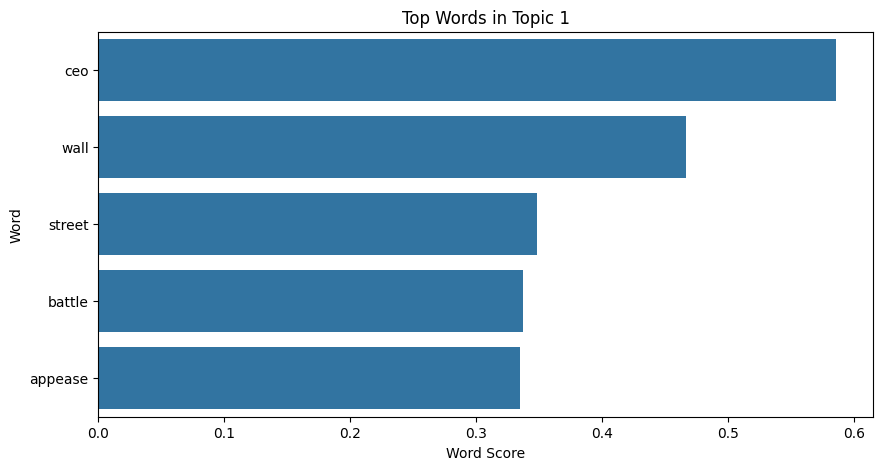

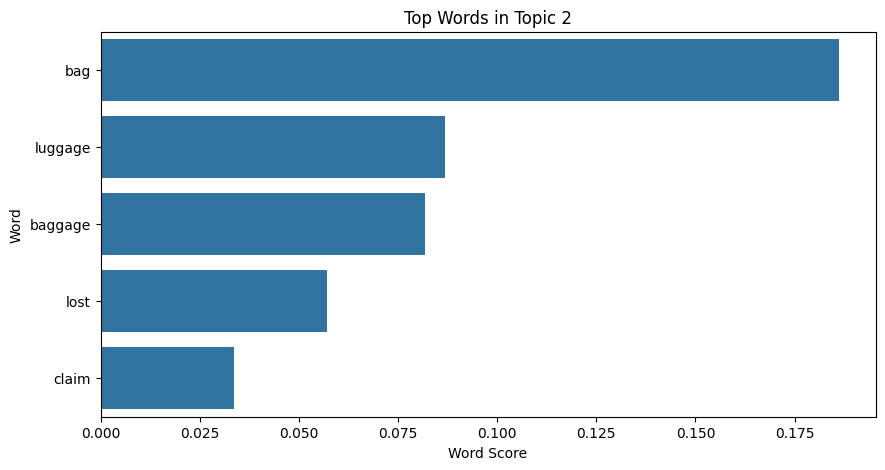

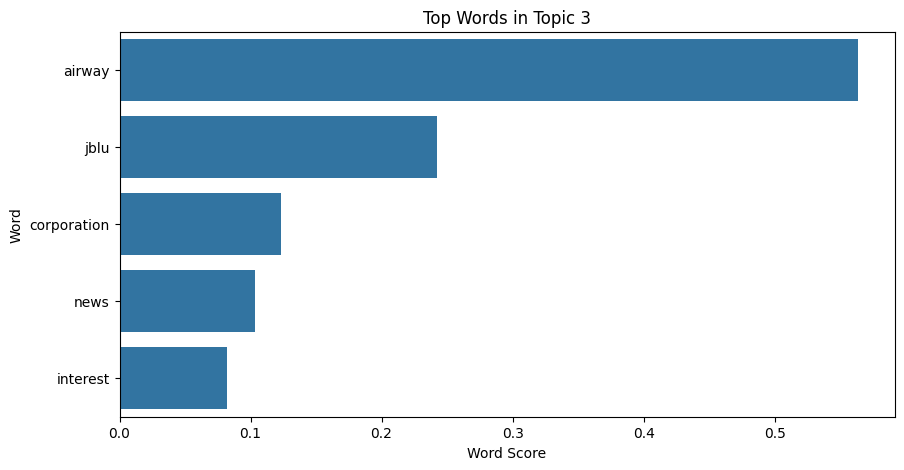

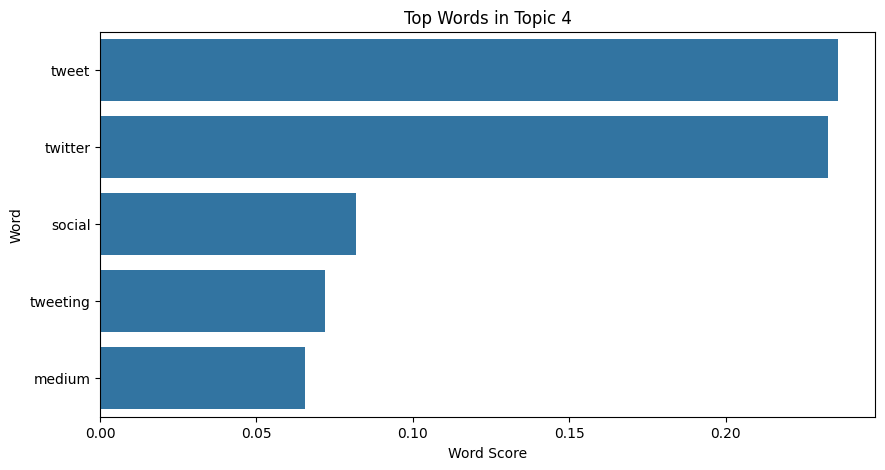

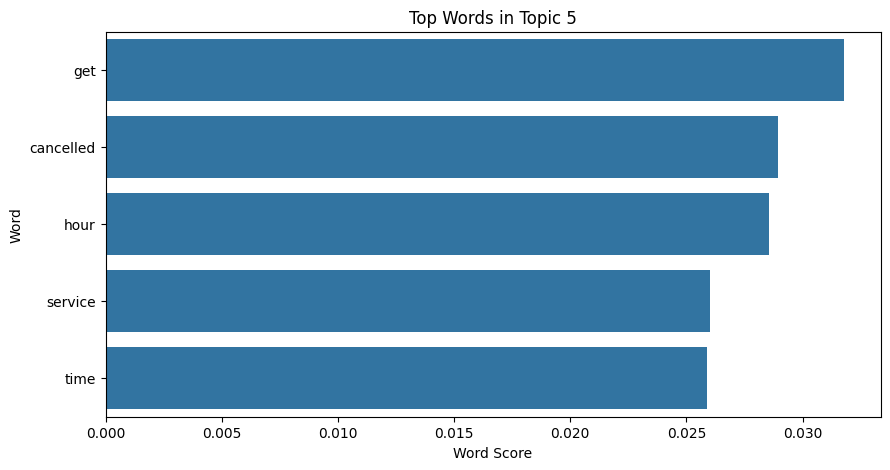

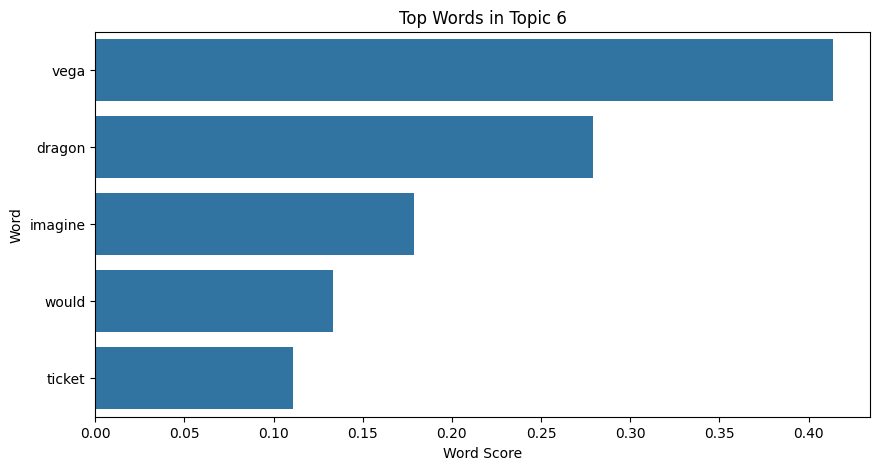

In [ ]:
import seaborn as sns

# Get top words per topic and plot
for topic in set(topics):
    if topic != -1:
        top_words = topic_model.get_topic(topic)
        words, scores = zip(*top_words)

        # Plot bar chart for top words in each topic
        plt.figure(figsize=(10, 5))
        sns.barplot(x=scores, y=words)
        plt.title(f"Top Words in Topic {topic}")
        plt.xlabel("Word Score")
        plt.ylabel("Word")
        plt.show()


##5.3 Intertopic Distance Map

The Intertopic Distance Map provides a spatial visualization of how different topics relate to each other in a two-dimensional space (D1 and D2). Key observations
* Topic 5 seems to be the primary theme in airline-related discussions
* The clear separation between some topics validates that the model has identified genuinely different themes in the tweets
* The positioning suggests some topics are more related (closer together) while others are more distinct (farther apart)

In [ ]:
# Visualize intertopic distance
topic_model.visualize_topics()

##5.4 Topic Distribution Bar Plot

This bar plot illustrates the distribution of tweets across the identified topics. Each bar represents a topic, and the height indicates the number of tweets associated with that topic.

From the plot, we observe that:

* Topic 5 has the highest number of tweets, indicating that this theme dominates the dataset. Customer service is a prevalent issue or sentiment in the airline tweets.

* Topic -1 also has a significant count, which represents tweets that couldn’t be assigned to any specific topic (often labeled as "outliers" or "miscellaneous"). This could mean there are tweets with varied content not well captured by the main topics.

* The remaining topics (0, 1, 2, 3, 4, and 6) have fewer tweets, suggesting these themes are less discussed or are more specific in nature.
Insights: This distribution shows that while the model captures several distinct themes, only a few topics, particularly Topic 5, account for the majority of discussions.

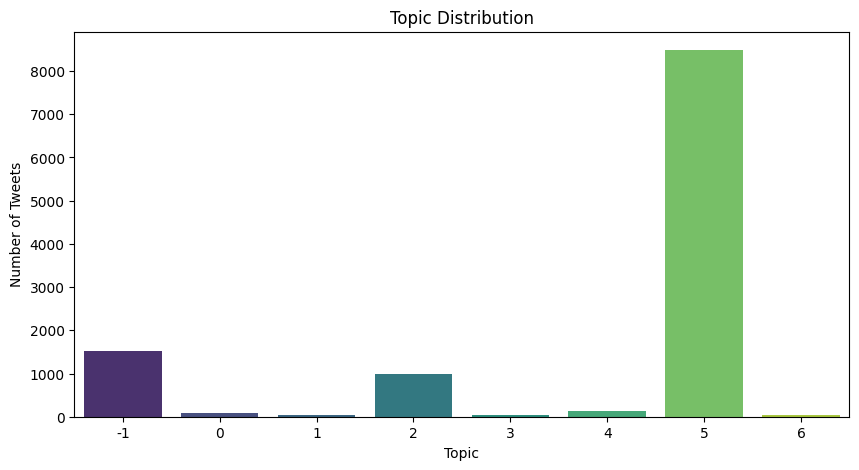

In [ ]:
# Get the count of tweets per topic
topic_counts = pd.Series(topics).value_counts()

# Plot the topic distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.show()


##5.5 Sentiment Distribution per Topic

This plot shows sentiment distribution (positive, neutral, negative) across topics in our dataset. Key findings:

* Topic 5 has the most tweets, mostly negative

* Topic -1 (outliers) shows mixed sentiments but leans negative

* Topics 2 and 4 have fewer tweets but are predominantly negative

* Topics 0, 1, 3, and 6 show minimal activity

The high volume of negative sentiment in Topic 5 suggests this area needs attention to improve customer satisfaction.

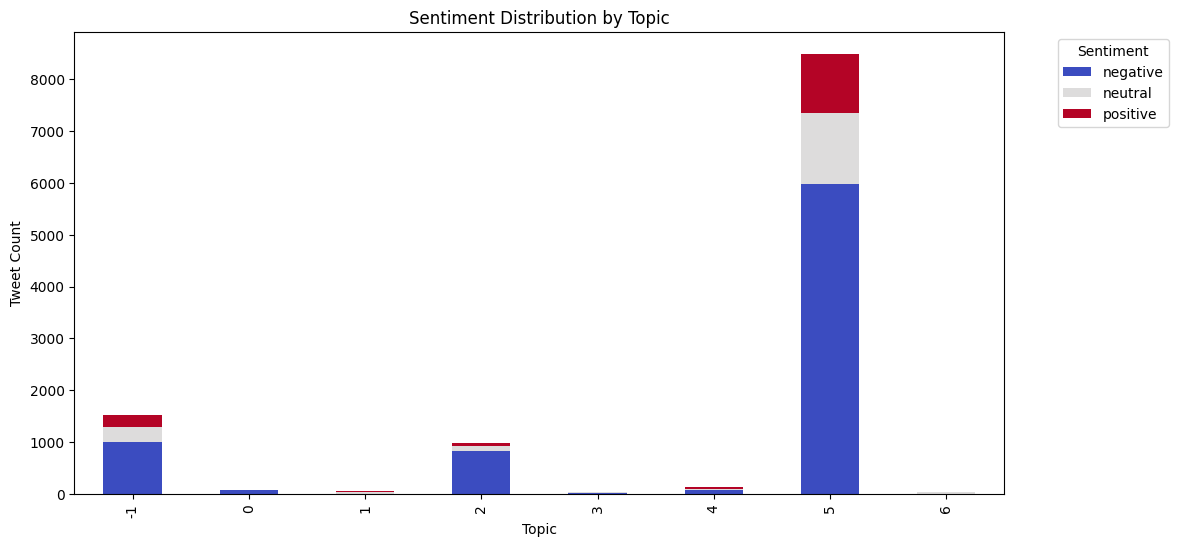

In [ ]:
# Prepare data for stacked bar chart
topic_sentiment_counts = tweets_df.groupby(['topic', 'airline_sentiment']).size().unstack().fillna(0)

# Plot stacked bar chart
topic_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Sentiment Distribution by Topic")
plt.xlabel("Topic")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


##5.6 UMAP Embedding Plot by Topic

This visualization shows the distribution of topics in a two-dimensional space using UMAP dimensionality reduction. Key points observed:


* Dominant central cluster in light blue, representing the majority of customer service-related tweets

* Several distinct topic clusters are identified (Topics -1, 0, 1, 3, 4, and 6)
There's some overlap between clusters, suggesting related themes in airline customer feedback

* Some overlap between topics, particularly in the main cluster area, indicating related discussions

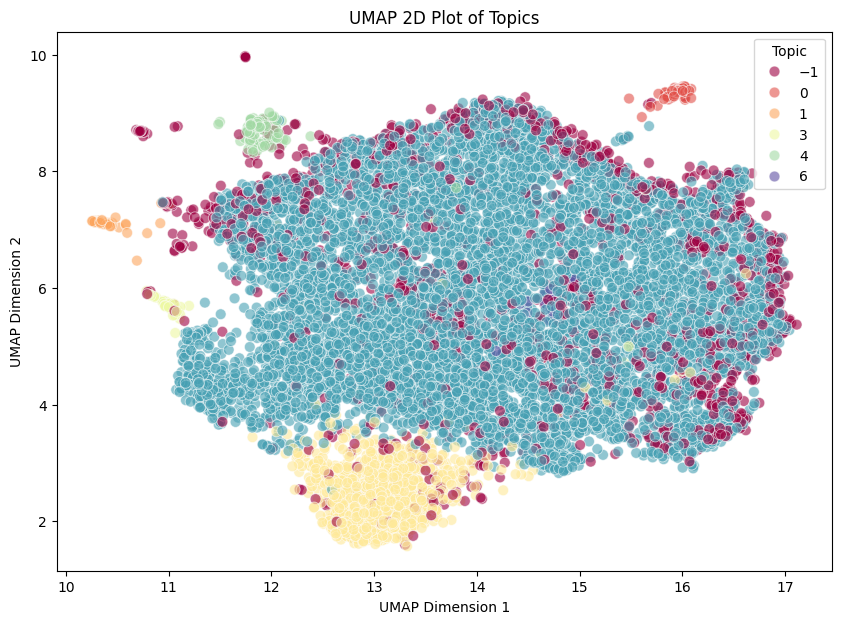

In [ ]:
# Generate UMAP embeddings
umap_embeddings = umap_model.fit_transform(embedding_model.encode(tweets_df["processed_text"].tolist()))

# Plot UMAP embeddings with color by topic
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=topics, palette="Spectral", s=60, alpha=0.6)
plt.title("UMAP 2D Plot of Topics")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Topic")
plt.show()


##5.7 Top Words by Sentiment

This comparison shows distinct vocabulary patterns across sentiment categories:


* Positive tweets are dominated by gratitude terms ("thanks", "thank", "great")
and service acknowledgment

* Neutral tweets focus on operational terms ("ticket", "help", "would")
Negative tweets show higher frequency of problem-related terms and appear to be more dominant

* This validates the topic modeling by showing clear linguistic differences between sentiment categories

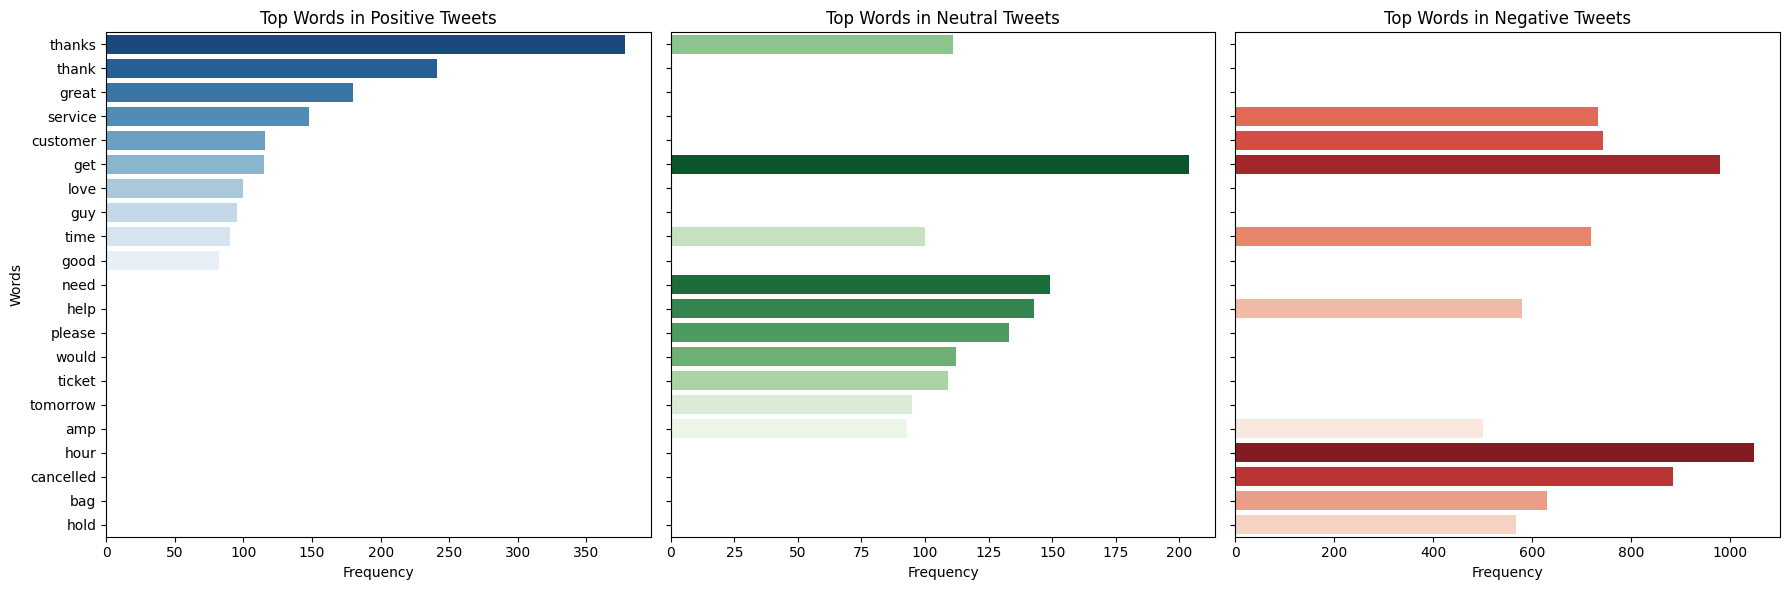

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Separate tweets by sentiment
positive_tweets = ' '.join(tweets_df[tweets_df['airline_sentiment'] == 'positive']['processed_text'])
neutral_tweets = ' '.join(tweets_df[tweets_df['airline_sentiment'] == 'neutral']['processed_text'])
negative_tweets = ' '.join(tweets_df[tweets_df['airline_sentiment'] == 'negative']['processed_text'])

# Calculate word frequencies
positive_words = Counter(positive_tweets.split())
neutral_words = Counter(neutral_tweets.split())
negative_words = Counter(negative_tweets.split())

# Plot top 10 words per sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Positive Sentiment
top_positive = dict(positive_words.most_common(10))
sns.barplot(x=list(top_positive.values()), y=list(top_positive.keys()), ax=axes[0], palette="Blues_r")
axes[0].set_title("Top Words in Positive Tweets")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Words")

# Neutral Sentiment
top_neutral = dict(neutral_words.most_common(10))
sns.barplot(x=list(top_neutral.values()), y=list(top_neutral.keys()), ax=axes[1], palette="Greens_r")
axes[1].set_title("Top Words in Neutral Tweets")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")

# Negative Sentiment
top_negative = dict(negative_words.most_common(10))
sns.barplot(x=list(top_negative.values()), y=list(top_negative.keys()), ax=axes[2], palette="Reds_r")
axes[2].set_title("Top Words in Negative Tweets")
axes[2].set_xlabel("Frequency")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


##5.8 Pairwise Similarity Heatmap between Topics

The heatmap reveals topic relationships:


**Strong Correlations (Similarity > 0.7)**

 * Topics 0 and 6 (0.93): Connectivity/Booking overlap
 * Topics 3 and 6 (0.72): Operations/Booking relationship
 * Topics 0 and 3 (0.70): Service delivery connection

**Moderate Correlations (0.4-0.7)**

 * Most topic pairs show moderate similarity
 * Indicates well-balanced topic distribution
 * Common customer service vocabulary

**Weak Correlations (< 0.4)**

 * Topics 1 and 2 (0.18): Corporate/Baggage distinction
 * Topics 2 and 7 (0.21): Operational separation
 * Validates topic model effectiveness



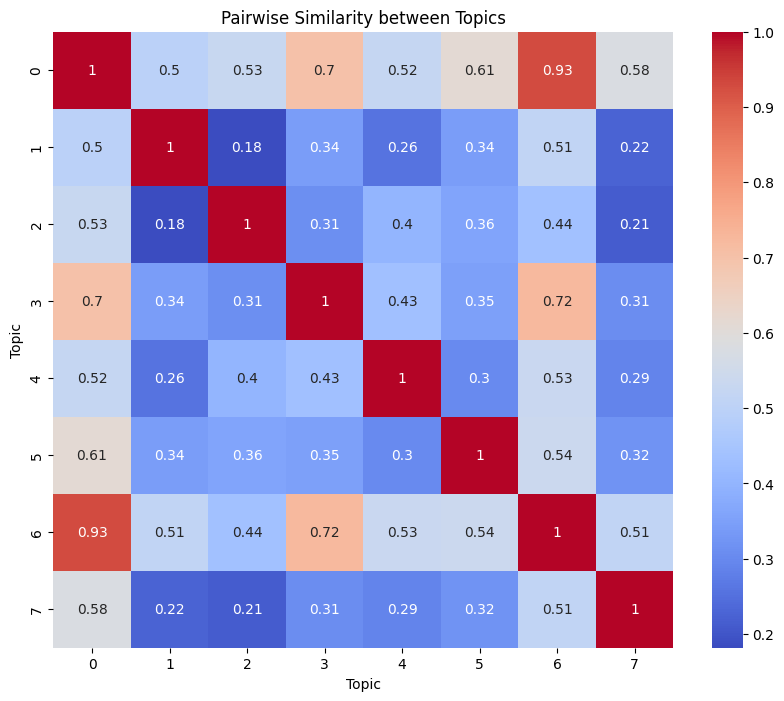

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Get topic embeddings
topic_embeddings = topic_model.topic_embeddings_

# Compute pairwise cosine similarity between topics
similarity_matrix = cosine_similarity(topic_embeddings)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=range(len(similarity_matrix)), yticklabels=range(len(similarity_matrix)), cmap="coolwarm", annot=True)
plt.title("Pairwise Similarity between Topics")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()
